Reference: https://www.kaggle.com/code/yomnahesham/cse616-final-project

ChatGPT was used to learn the original code in the reference.

book: SEBASTIAN LIU YUXI (HAYDEN) MIRJALILI VAHID RASCHKA - MACHINE LEARNING WITH PYTORCH AND SCIKIT-LEARN _ develop machine learning and deep learning... models with scikit-learn and pyto (2022, PACKT PUBLISHING

## Preparation

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 18 22:51:03 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Upload the data folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.3 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import itertools
import pandas as pd
import numpy as np
from scipy import stats
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
import neurokit2 as nk
import pywt
import torch.nn.functional as F
import itertools

In [ ]:
# Plot settings
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"]=(30,6)
plt.rcParams['lines.linewidth']=1
plt.rcParams['lines.color']='b'
plt.rcParams['axes.grid']=True

In [ ]:
# construct dataloader
class EcgDataset(Dataset):
  def __init__(self, X, y):
    self.X=X
    self.y=y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
# variables
path = '/content/drive/MyDrive/mitbih_database/'
window_size=180
maximum_counting =10000

# N represents normal, 'L', 'R', 'A', 'V' are four differents types of
# arrthymias.
classes=['N', 'L', 'R', 'A', 'V']
n_classes=len(classes)
count_classes=[0]*n_classes

In [ ]:
# Denoise with wavelet method
def denoise(data):
  w=pywt.Wavelet('sym4')
  maxlev=pywt.dwt_max_level(len(data), w.dec_len)
  threshold= 0.04

  coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
  for i in range(1, len(coeffs)):
    coeffs[i]=pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

  datarec=pywt.waverec(coeffs, 'sym4')

  return datarec

In [ ]:
# Prepare input files
import os

filenames = next(os.walk(path))[2]

records=list()
annotations=list()
filenames.sort()

# separate csv and txt files, csv are heartbeats, txt are annotations
for name in filenames:
  filename, file_extension = os.path.splitext(name)

  # *.csv
  if(file_extension == '.csv'):
    records.append(path + filename + file_extension)

  # *.txt
  else:
    annotations.append(path + filename + file_extension)

In [ ]:
# check
print(records)

['/content/drive/MyDrive/mitbih_database/100.csv', '/content/drive/MyDrive/mitbih_database/101.csv', '/content/drive/MyDrive/mitbih_database/102.csv', '/content/drive/MyDrive/mitbih_database/103.csv', '/content/drive/MyDrive/mitbih_database/104.csv', '/content/drive/MyDrive/mitbih_database/105.csv', '/content/drive/MyDrive/mitbih_database/106.csv', '/content/drive/MyDrive/mitbih_database/107.csv', '/content/drive/MyDrive/mitbih_database/108.csv', '/content/drive/MyDrive/mitbih_database/109.csv', '/content/drive/MyDrive/mitbih_database/111.csv', '/content/drive/MyDrive/mitbih_database/112.csv', '/content/drive/MyDrive/mitbih_database/113.csv', '/content/drive/MyDrive/mitbih_database/114.csv', '/content/drive/MyDrive/mitbih_database/115.csv', '/content/drive/MyDrive/mitbih_database/116.csv', '/content/drive/MyDrive/mitbih_database/117.csv', '/content/drive/MyDrive/mitbih_database/118.csv', '/content/drive/MyDrive/mitbih_database/119.csv', '/content/drive/MyDrive/mitbih_database/121.csv',

In [ ]:
# Data extraction and prepocessing

def read_csv_file(filename):
  return pd.read_csv(filename, delimiter=',', header=None, skiprows=1).iloc[:,1].tolist()

def read_annotations(filename):
  with open(filename, 'r') as fileID:
    return fileID.readlines()[1:]

def process_signal(signals, record_num):
  if record_num ==1:
    plot_signal(signals, title=f'{records[record_num]} Wave')

  signals = denoise(signals)
  if record_num ==1:
    plot_signal(signals, title=f'{records[record_num]} Wave after denoise')

  signals=stats.zscore(signals)
  if record_num ==1:
    plot_signal(signals, title=f'{records[record_num]} Wave after z-score normalization')

  return signals

def plot_signal(signal, title="", samples =700):
  plt.title(title)
  plt.plot(signal[:samples])
  plt.show()

def extract_beats_from_signal(signals, annotation_data, classes, window_size):
  X, y = [], []
  for data in annotations_data:
    splitted = data.split()
    pos= int(splitted[1])
    arrhythmia_type=splitted[2]
    # print(arrhythmia_type)

    if arrhythmia_type in classes:
      arrhythmia_index = classes.index(arrhythmia_type)
      if window_size <= pos < (len(signals) -window_size):
        beat=signals[pos-window_size:pos+window_size]
        X.append(beat)
        y.append(arrhythmia_index)

  return X,y

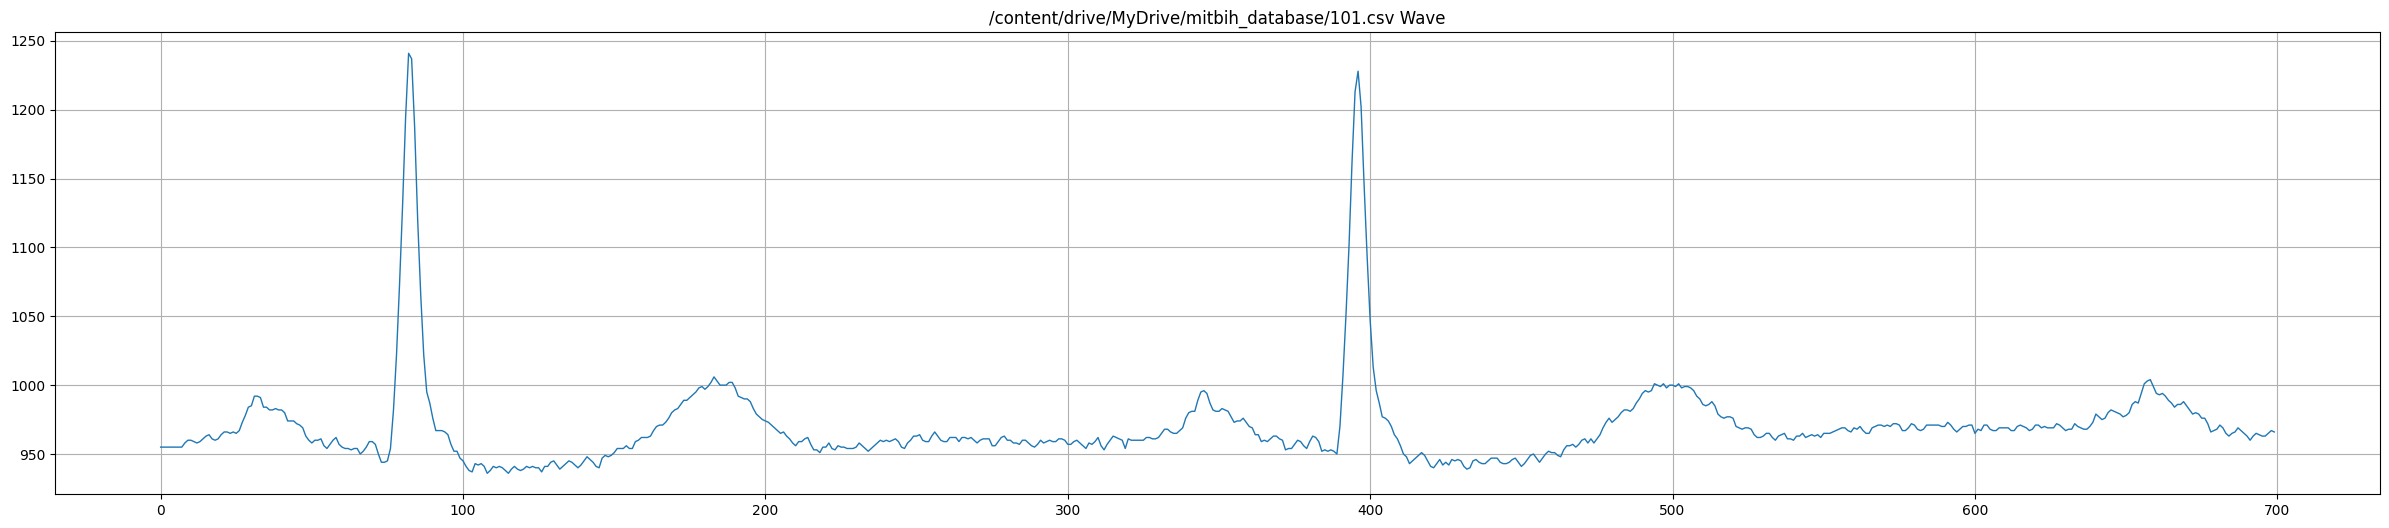

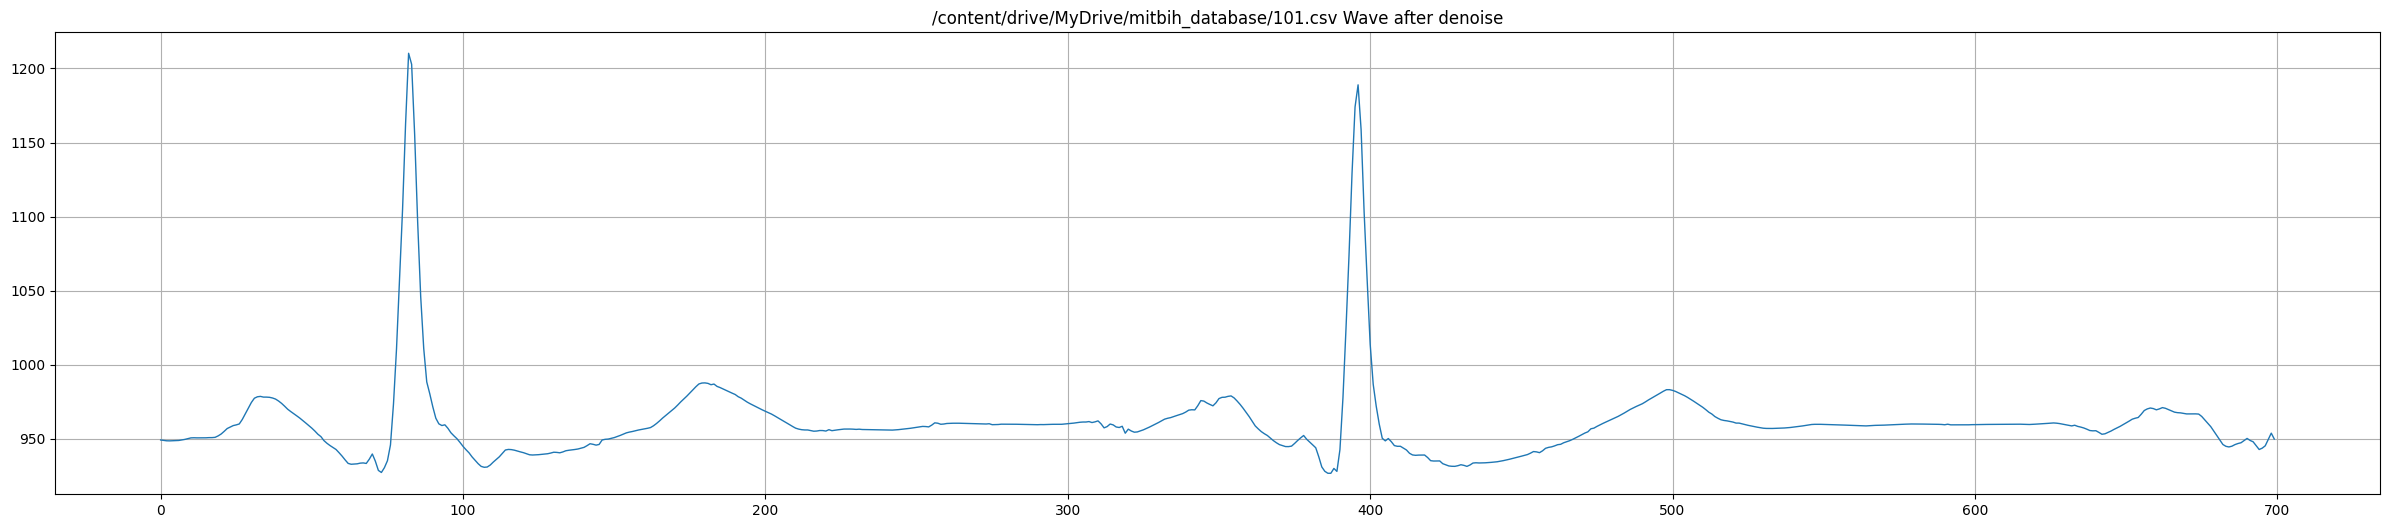

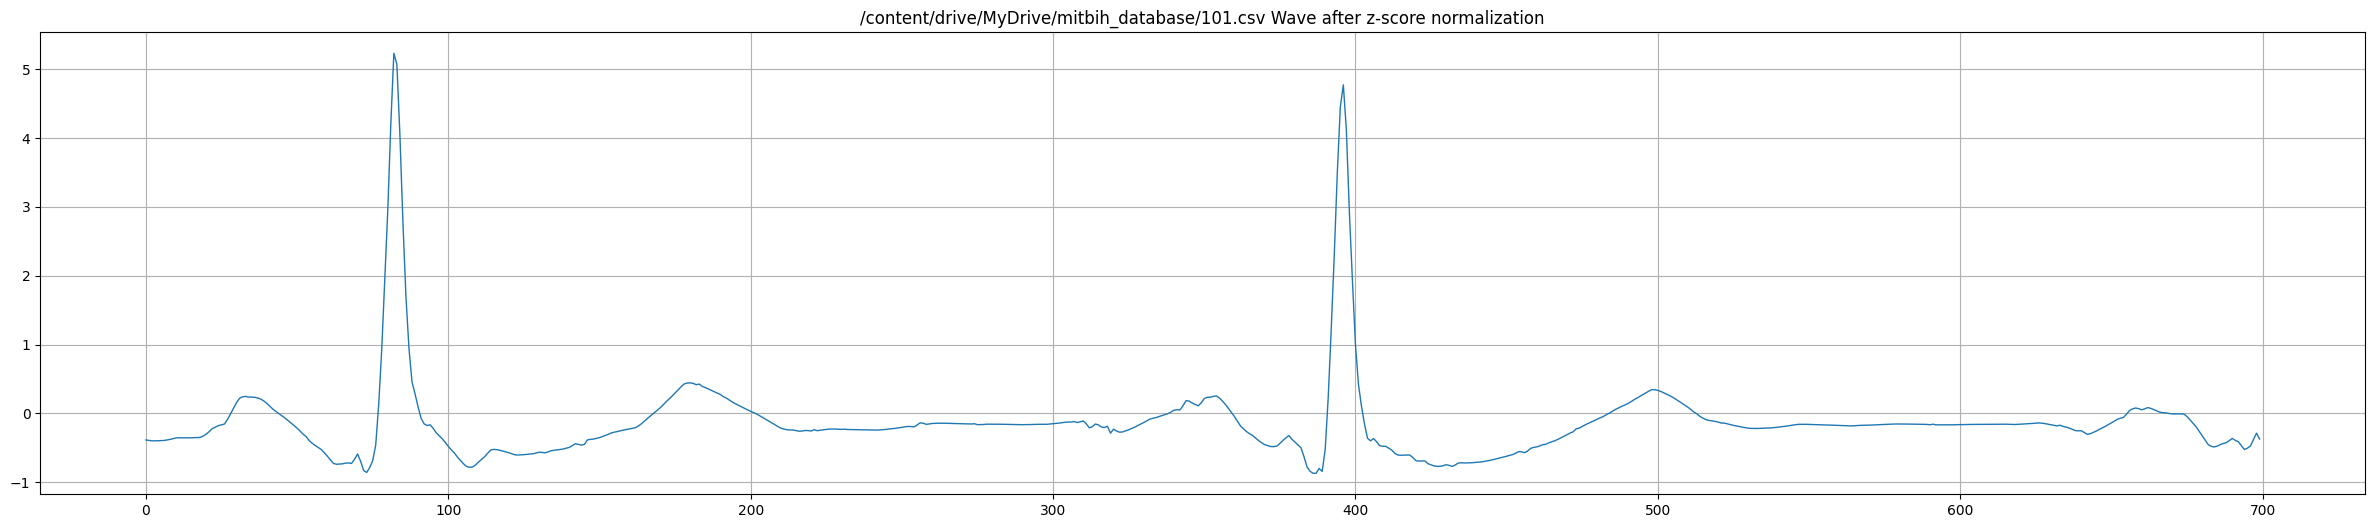

(100012, 360) (100012,)
[0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# negative optimize
def extract_beats_from_signal_01(signals, annotation_data, classes, window_size):
  # convert annotation data to Dataframe for vectorized operations
  annotations_df =pd.DataFrame([line.split() for line in annotation_data], columns=['Time', 'Sample #', 'Type', 'Sub', 'Chan', 'Num', 'Aux'])
  annotations_df['Sample #'] = annotations_df['Sample #'].astype(int)

  annotations_df=annotations_df[annotations_df['Type'].isin(classes)]

  X = [signals[pos-window_size:pos+window_size] for pos in annotations_df['Sample #'] if window_size <= pos < (len(signals) -window_size)]
  y = [classes.index(arrhythmia) for arrhythmia in annotations_df['Type']]

  return X, y

# create X,y
X=list()
y=list()

# process records
for r, record in enumerate(records):
  signals=read_csv_file(record)
  signals=process_signal(signals, r)

  annotations_data= read_annotations(annotations[r])
  X_temp, y_temp = extract_beats_from_signal(signals,annotations_data, classes, window_size)
  X.extend(X_temp)
  y.extend(y_temp)

print(np.shape(X), np.shape(y))
print(y)

In [ ]:
# plt.plot(X[4])
# print(y[4])

In [ ]:

# Convert X and y into PyTorch tensors C.
# X_tensor = torch.tensor(X, dtype=torch.float32)
# y_tensor = torch.tensor(y, dtype=torch.float32)
X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
y_tensor = torch.tensor(np.array(y), dtype=torch.float32)

# test normalizaton of data
X_normalized_tensor = 2 * (X_tensor / 6) - 1
dataset = EcgDataset(X_normalized_tensor, y_tensor)

# dataset=EcgDataset(X_tensor, y_tensor)

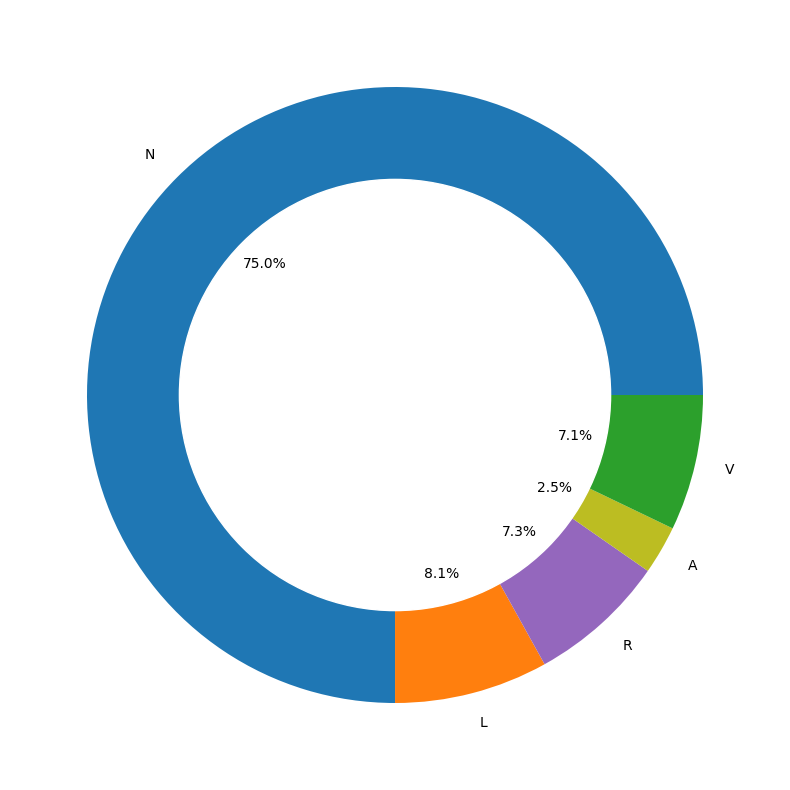

In [ ]:
unique_labels, counts = y_tensor.unique(return_counts=True)
distribution = dict(zip(unique_labels.tolist(), counts.tolist()))

plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(distribution.values(), labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
# Pingheng balance dataset
def upsample_class(X, y, class_label, target_samples):
  mask=(y==class_label)
  X_class=X[mask]
  y_class=y[mask]

  current_samples=len(X_class)
  extra_samples=target_samples - current_samples

  indices = np.random.choice(range(current_samples), extra_samples)
  X_extra=X_class[indices]
  y_extra=y_class[indices]

  X_upsampled=torch.cat([X_class, X_extra], dim = 0)
  y_upsampled=torch.cat([y_class, y_extra], dim=0)

  return X_upsampled, y_upsampled

def downsample_class(X,y, class_label, target_samples):
  mask=(y==class_label)
  X_class=X[mask]
  y_class=y[mask]

  indices= np.random.choice(range(len(X_class)), target_samples, replace=False)
  X_downsampled=X_class[indices]
  y_downsampled=y_class[indices]

  return X_downsampled, y_downsampled

def process_classes(X,y, target_samples=5000):
  classes, counts = torch.unique(y, return_counts=True)
  X_list, y_list=[], []

  for class_label, count in zip(classes, counts):
    if count < target_samples:
      X_processed, y_processed= upsample_class(X,y, class_label.item(), target_samples)
    else:
      X_processed, y_processed= downsample_class(X,y,class_label.item(), target_samples)
    X_list.append(X_processed)
    y_list.append(y_processed)

  X_balanced= torch.cat(X_list, dim=0)
  y_balanced=torch.cat(y_list, dim=0)

  return X_balanced, y_balanced

In [ ]:
X_balanced, y_balanced= process_classes(X_tensor, y_tensor)
balanced_dataset = EcgDataset(X_balanced, y_balanced)

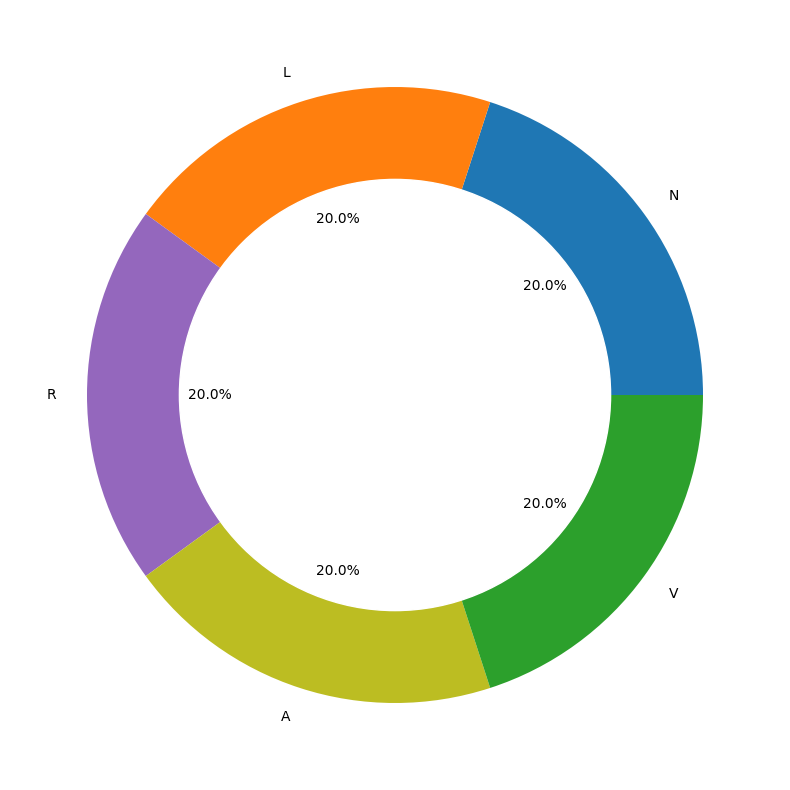

In [ ]:
# plot balanced dataset
unique_labels, counts = y_balanced.unique(return_counts=True)
distribution = dict(zip(unique_labels.tolist(), counts.tolist()))

plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(distribution.values(), labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
# slit the data
torch.manual_seed(1)
np.random.seed(1)
train_data, valid_data = random_split(balanced_dataset, [15000, 10000])

# Try use unbalanced dataset
# train_data, valid_data = random_split(dataset, [50000, 50012])

# Yong DataLoader lai batching, shuffling, etc.
batch_size=32
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True , drop_last=True)
valid_loader=DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=True)

## CNN Classifier

In [ ]:
# Classifier
import torch.nn as nn
model= nn.Sequential()

# conv1
model.add_module(
    'conv1',
    nn.Conv1d(
        in_channels=1, out_channels=16, kernel_size=13, padding=6
    )
)

# relu, pooling layers
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.AvgPool1d(kernel_size=3, stride=2))

#x = torch.ones(4, 1, 360)
#model(x).shape
#torch.Size([4, 16, 179])

# conv2
model.add_module(
    'conv2',
    nn.Conv1d(
        in_channels=16, out_channels= 32, kernel_size=15, padding=7
    )
)

# relu, pooling layers
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.AvgPool1d(kernel_size=3, stride=2))

# conv3
model.add_module(
    'conv3',
    nn.Conv1d(
        in_channels=32, out_channels= 64, kernel_size=17, padding=8
    )
)

# relu, pooling layers
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.AvgPool1d(kernel_size=3, stride=2))

# conv4
model.add_module(
    'conv4',
    nn.Conv1d(
        in_channels=64, out_channels= 128, kernel_size=19, padding=9
    )
)

# relu, pooling layers
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.AvgPool1d(kernel_size=3, stride=2))

# Flattenning
model.add_module('flatten', nn.Flatten())

#x= torch.ones((4,1,360))
#model(x).shape
#torch.Size([4, 2688])

# dropout
model.add_module('dropout', nn.Dropout(p=0.5))

# dense layers with regularizatiion
model.add_module('fc1', nn.Linear(2688, 35))

#x= torch.ones((4,1,360))
#model(x).shape
#torch.Size([4, 35])

# dense layers with regularizatiion
model.add_module('fc2', nn.Linear(35, 5))

# Softmatrix layer
model.add_module('soft', nn.LogSoftmax(dim=None))

In [ ]:
# Dummy input
# dummy_input = torch.randn(32, 1, 360)
# output = model(dummy_input)
# print(output.shape)

# print(model)

NameError: ignored

In [ ]:
# for inputs, labels in train_loader:
# print(inputs)
#  print(inputs.shape)
#  break

In [ ]:
# train method
loss_fn =nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
def train(model, num_epochs, train_dl, valid_dl):
  loss_hist_train =[0]*num_epochs
  accuracy_hist_train=[0]*num_epochs
  loss_hist_valid=[0]*num_epochs
  accuracy_hist_valid=[0]*num_epochs

  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      x_batch=x_batch.unsqueeze(1)
      y_batch=y_batch.long()
      pred = model(x_batch)
      loss=loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()*y_batch.size(0)
      is_correct =(
          torch.argmax(pred, dim=1) == y_batch
      ).float()
      accuracy_hist_train[epoch] +=is_correct.sum()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /=len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
      for x_batch, y_batch in valid_dl:
        x_batch=x_batch.unsqueeze(1)
        y_batch=y_batch.long()
        pred = model(x_batch)
        loss=loss_fn(pred,y_batch)
        loss_hist_valid[epoch] += \
          loss.item()*y_batch.size(0)
        is_correct=(
            torch.argmax(pred, dim=1)==y_batch
        ).float()
        accuracy_hist_valid[epoch] += is_correct.sum()
    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f'Epoch {epoch+1} accuracy: '
          f'{accuracy_hist_train[epoch]: .4f} val_accuracy: '
          f'{accuracy_hist_valid[epoch]: .4f}')
  return loss_hist_train, loss_hist_valid, \
         accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)
num_epochs=20
hist=train(model, num_epochs, train_loader, valid_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1 accuracy:  0.8544 val_accuracy:  0.9440
Epoch 2 accuracy:  0.9466 val_accuracy:  0.9671
Epoch 3 accuracy:  0.9573 val_accuracy:  0.9444
Epoch 4 accuracy:  0.9647 val_accuracy:  0.9648
Epoch 5 accuracy:  0.9705 val_accuracy:  0.9821
Epoch 6 accuracy:  0.9765 val_accuracy:  0.9775
Epoch 7 accuracy:  0.9758 val_accuracy:  0.9824
Epoch 8 accuracy:  0.9788 val_accuracy:  0.9812
Epoch 9 accuracy:  0.9826 val_accuracy:  0.9836
Epoch 10 accuracy:  0.9850 val_accuracy:  0.9773
Epoch 11 accuracy:  0.9834 val_accuracy:  0.9851
Epoch 12 accuracy:  0.9835 val_accuracy:  0.9869
Epoch 13 accuracy:  0.9872 val_accuracy:  0.9871
Epoch 14 accuracy:  0.9865 val_accuracy:  0.9817
Epoch 15 accuracy:  0.9873 val_accuracy:  0.9830
Epoch 16 accuracy:  0.9882 val_accuracy:  0.9820
Epoch 17 accuracy:  0.9917 val_accuracy:  0.9842
Epoch 18 accuracy:  0.9902 val_accuracy:  0.9825
Epoch 19 accuracy:  0.9899 val_accuracy:  0.9858
Epoch 20 accuracy:  0.9918 val_accuracy:  0.9837


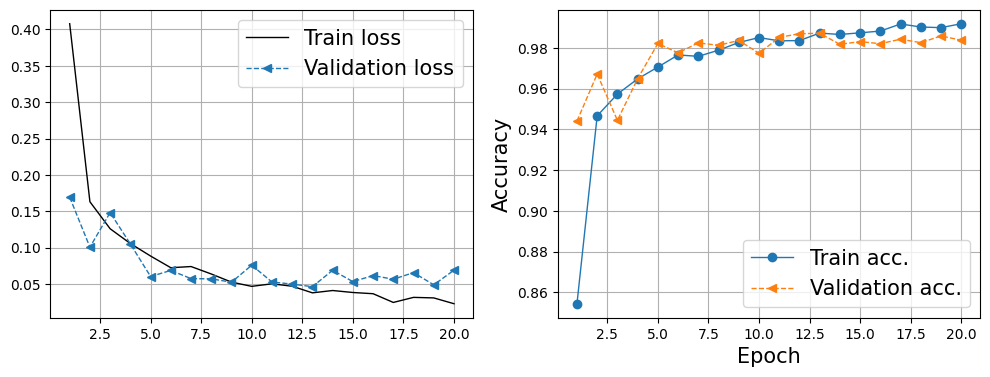

In [ ]:
# plot learning curves
x_arr =np.arange(len(hist[0]))+1
fig = plt.figure(figsize=(12,4))
ax=fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-0', label = 'Train loss')
ax.plot(x_arr, hist[1], '--<', label= 'Validation loss')
ax.legend(fontsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [ ]:
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dic': optimizer.state_dict(),
}, '/content/drive/MyDrive/Abschlussarbeit_ECG/model/classifier_model.pth')

## Data evaluation

In [ ]:
# Load model and optimizer state
checkpoint = torch.load('/content/drive/MyDrive/Abschlussarbeit_ECG/model/classifier_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Evaluate from file


In [ ]:
# Evaluatie the ECG_beats from file
file_path = '/content/drive/MyDrive/Abschlussarbeit_ECG/16_12_PGAN/epoch_5.csv'
data = pd.read_csv(file_path)

In [ ]:
file_path = '/content/drive/MyDrive/Abschlussarbeit_ECG/WGAN_17_12_1856/epoch_99.csv'
data2 = pd.read_csv(file_path)

X_unknown = list()
y_unknown = list()
for i in range(31):
  beat_str=data2.iloc[i]

  b_str =beat_str[0].replace('\n', ' ').split()
  b_str=b_str[1:]
  if(len(b_str) == 359):
    tmp = b_str[0]
    b_str.insert(0, tmp)
  # print(len(b_str))

  temp=b_str[359]
  temp=temp.strip(']')
  b_str[359]= temp
  # stripped_list = [item.strip(']') for item in b_str]
  # print(f'lastone: {b_str[358]} and length: {len(b_str)}')
  numbers_float = [float(num) for num in b_str]
  vector= np.array(numbers_float)

  X_unknown.append(vector)
  y_unknown.append(1)


### Evaluate directly after train


In [ ]:
# Inception score calculator
def is_score(predictions):
  # calculate p(y|x)
  row_sums = predictions.sum(dim=1, keepdim=True)
  p_y_x= predictions /row_sums

  # calculate p(y)
  p_y = torch.mean(p_y_x, dim=0)

  # KL divergence
  y_dist= dist.Categorical(probs=p_y)
  kl_divergences = torch.zeros(p_y_x.size(0))

  for i, row in enumerate(p_y_x):
    row_dist= dist.Categorical(probs=row)
    kl_divergences[i] = dist.kl_divergence(row_dist, y_dist)

  # exponential of everage
  average = torch.mean(kl_divergences)
  # print(average)
  return torch.exp(average)

In [ ]:
X_unknown = np.array(vani_epoch_samples[99].squeeze(1))
# print(X_unkown)
y_unknown = np.ones(len(X_unknown))
# X_unkown = np.array(X_unknown)

In [ ]:
batch_size=32
# Create the dataset
X_unknown_tensor = torch.tensor(np.array(X_unknown), dtype=torch.float32)
y_unknown_tensor = torch.tensor(np.array(y_unknown), dtype=torch.float32)
# print(X_unknown.shape)
unknown_dataset = EcgDataset(X_unknown, y_unknown)

unknown_loader=DataLoader(unknown_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Ensure the model is in evaluation mode
model.eval()
model.double()

predictions = []
# Iterate over DataLoader and get predictions
for x_batch, y_batch in unknown_loader:
    # print(batch.shape)
    x_batch= x_batch.unsqueeze(1)
    predictions = model(x_batch.double())
    # Process predictions as needed
    # print(predictions)
    break


In [ ]:
# print(predictions.shape)
# print(predictions[1])

In [ ]:
isscore = is_score(predictions)
print(isscore)

tensor(1.0003, grad_fn=<ExpBackward0>)


## Utilities

In [ ]:
print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device="cpu"

print(device)

2.1.0+cu121
GPU Available: True
cuda:0


In [ ]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size,1)*2 -1
  elif mode_z =='normal':
    input_z = torch.randn(batch_size, z_size,1)
  return input_z

In [ ]:
# the scaling here can be a problem
# Try no scaling
# Try scale to [-1, 6] with (heartbeats - (-1))*7/2 - 1
def create_samples(g_model, input_z):
  g_output=g_model(input_z)
  heartbeats=torch.reshape(g_output, (batch_size, *hb_size))
  return heartbeats

## WGAN

### set up

In [ ]:
# WGAN Generator and discriminator
def make_generator_network_wgan(input_size, n_filters):
  model=nn.Sequential(
      # input_size*1
      nn.ConvTranspose1d(input_size, n_filters*8, 10, 1, 0, bias= False),
      nn.InstanceNorm1d(n_filters*8),
      nn.LeakyReLU(0.2),

      # shape: 128*3
      nn.ConvTranspose1d(n_filters*8, n_filters*4, 3, 3, 0, bias=False),
      nn.InstanceNorm1d(n_filters*4),
      nn.LeakyReLU(0.2),

      # shape: 64*30
      nn.ConvTranspose1d(n_filters*4, n_filters*2, 3, 3, 0, bias=False),
      nn.InstanceNorm1d(n_filters*2),
      nn.LeakyReLU(0.2),

      # shape: 32*90
      nn.ConvTranspose1d(n_filters*2, n_filters, 4, 2, 1, bias=False),
      nn.InstanceNorm1d(n_filters),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose1d(n_filters, 1, 4, 2, 1, bias=False),
      # nn.Tanh()
  )
  return model

class DiscriminatorWGAN(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.network=nn.Sequential(
        # Input 1*360
        nn.Conv1d(1, n_filters, kernel_size=5, stride=2, padding=2, bias=False),
        nn.LeakyReLU(0.2),

        # Input 32*180
        nn.Conv1d(n_filters,n_filters*2, 5, 2, 2, bias=False),
        nn.InstanceNorm1d(n_filters*2),
        nn.LeakyReLU(0.2),

        # Input 64*90
        nn.Conv1d(n_filters*2, n_filters*4, 5, 3, 2, bias=False),
        nn.InstanceNorm1d(n_filters*4),
        nn.LeakyReLU(0.2),

        # Input 128*30
        nn.Conv1d(n_filters*4, n_filters*8, 5, 10, 2, bias=False),
        nn.InstanceNorm1d(n_filters*8),
        nn.LeakyReLU(0.2),

        #
        nn.Conv1d(n_filters*8, 1, 3, 1, 0, bias=False),
        # Try
        # nn.Sigmoid()
    )

  def forward(self, input):
    output = self.network(input)
    return output.view(-1,1).squeeze(0)

In [ ]:
# test
# input_z = create_noise(32, z_size, 'normal').to(device)
# g_output=gen_model(input_z)
# print(g_output.shape)
# print(g_output)

In [ ]:
# create WGAN model
z_size=100
n_filters =16
hb_size=(1, 360)
gen_model = make_generator_network_wgan(
    z_size, n_filters
).to(device)
disc_model= DiscriminatorWGAN(n_filters).to(device)

# initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('InstanceNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

gen_model.apply(weights_init)
disc_model.apply(weights_init)

# Adam
# g_optimizer=torch.optim.Adam(gen_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
# d_optimizer=torch.optim.Adam(disc_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# RMSprop
g_optimizer=torch.optim.Adam(gen_model.parameters(), lr=0.00005)
d_optimizer=torch.optim.Adam(disc_model.parameters(), lr=0.00005)

In [ ]:
print(gen_model)
print(disc_model)

Sequential(
  (0): ConvTranspose1d(100, 128, kernel_size=(10,), stride=(1,), bias=False)
  (1): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(3,), bias=False)
  (4): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(3,), bias=False)
  (7): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
  (10): InstanceNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (11): LeakyReLU(negative_slope=0.2)
  (12): ConvTranspose1d(16, 1, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
)
DiscriminatorWGAN(
  (network): Sequential(
    (0): Conv1d(1, 16

In [ ]:
from torch.autograd import grad as torch_grad
def gradient_penalty(real_data, generated_data):
  # print(real_data.shape)
  # print(generated_data.shape)
  #print(interpolated.shape)
  batch_size= real_data.size(0)

  alpha = torch.rand(real_data.shape[0], 1, 1,
                     requires_grad=True, device=device)
  interpolated=alpha*real_data +\
               (1-alpha)*generated_data

  proba_interpolated = disc_model(interpolated)

  gradients = torch_grad(
      outputs=proba_interpolated, inputs=interpolated,
      grad_outputs=torch.ones(proba_interpolated.size(),
                              device=device),
      create_graph=True, retain_graph=True
  )[0]

  gradients = gradients.view(batch_size,-1)
  gradients_norm = gradients.norm(2, dim=1)
  return lambda_gp*((gradients_norm -1)**2).mean()

In [ ]:
mode_z = 'uniform'
fixed_z=create_noise(batch_size, z_size, mode_z).to(device)

In [ ]:
def d_train_wgan(x):
  disc_model.zero_grad()

  batch_size=x.size(0)
  x = x.to(device)

  d_real = disc_model(x)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output=gen_model(input_z)
  d_generated= disc_model(g_output)
  d_loss=d_generated.mean() -d_real.mean() +\
         gradient_penalty(x.data, g_output.data)
  d_loss.backward()
  d_optimizer.step()
  return d_loss.data.item(), d_real, d_generated

def g_train_wgan(x):
  gen_model.zero_grad()

  batch_size=x.size(0)
  input_z=create_noise(batch_size, z_size, mode_z).to(device)
  g_output=gen_model(input_z)

  d_generated= disc_model(g_output)
  g_loss=-d_generated.mean()

  g_loss.backward()
  g_optimizer.step()
  return g_loss.data.item()

### Train process and after

In [ ]:
# train wgan process
epoch_samples_wgan = []
lambda_gp=10.0
num_epochs=100
torch.manual_seed(1)
critic_iterations=5

all_d_losses=[]
all_g_losses=[]
all_d_real=[]
all_d_fake=[]
for epoch in range(1, num_epochs+1):
  gen_model.train()
  d_losses,g_losses=[],[]
  d_vals_real, d_vals_fake=[], []
  for i, (x,_) in enumerate(train_loader):
    x=x.unsqueeze(1)
    for _ in range(critic_iterations):
      d_loss, d_proba_real, d_proba_fake = d_train_wgan(x)
    d_losses.append(d_loss)
    g_losses.append(g_train_wgan(x))
    d_vals_real.append(d_proba_real.mean().cpu())
    d_vals_fake.append(d_proba_fake.mean().cpu())

  all_d_losses.append(torch.tensor(d_losses).mean())
  all_g_losses.append(torch.tensor(g_losses).mean())
  all_d_real.append(torch.tensor(d_vals_real).mean())
  all_d_fake.append(torch.tensor(d_vals_fake).mean())

  print(f'Epoch {epoch:03d} | D Loss >>'
        f' {torch.FloatTensor(d_losses).mean(): .4f}')
  gen_model.eval()
  epoch_samples_wgan.append(
      create_samples(
          gen_model, fixed_z
      ).detach().cpu().numpy()
  )

Epoch 001 | D Loss >>  35.8676
Epoch 002 | D Loss >>  3.1638
Epoch 003 | D Loss >>  2.5318
Epoch 004 | D Loss >>  1.5801
Epoch 005 | D Loss >>  1.6857
Epoch 006 | D Loss >>  1.9923
Epoch 007 | D Loss >>  1.6935
Epoch 008 | D Loss >>  1.4374
Epoch 009 | D Loss >>  1.2653
Epoch 010 | D Loss >>  1.1432
Epoch 011 | D Loss >>  0.9832
Epoch 012 | D Loss >>  0.9351
Epoch 013 | D Loss >>  0.8940
Epoch 014 | D Loss >>  0.9013
Epoch 015 | D Loss >>  0.9284
Epoch 016 | D Loss >>  0.8577
Epoch 017 | D Loss >>  1.2948
Epoch 018 | D Loss >>  1.1196
Epoch 019 | D Loss >>  0.9095
Epoch 020 | D Loss >>  1.1666
Epoch 021 | D Loss >>  0.7376
Epoch 022 | D Loss >>  0.7018
Epoch 023 | D Loss >>  1.0099
Epoch 024 | D Loss >>  0.8365
Epoch 025 | D Loss >>  1.3004
Epoch 026 | D Loss >>  1.0216
Epoch 027 | D Loss >>  0.5668
Epoch 028 | D Loss >>  0.4663
Epoch 029 | D Loss >>  0.4300
Epoch 030 | D Loss >>  0.3189
Epoch 031 | D Loss >>  0.3003
Epoch 032 | D Loss >>  0.0333
Epoch 033 | D Loss >>  0.2152
Epoch 034

In [ ]:

# save the generated data to csv file
import csv
from google.colab import files

for epoch_index, epoch_data in enumerate(epoch_samples_wgan):
    # Reshape the data for the current epoch to a 2D array of shape (32, 360).
    epoch_data_array = np.array(epoch_data).reshape(-1, 360)

    # Define the filename for the current epoch.
    filename = f'/content/drive/MyDrive/Abschlussarbeit_ECG/WGAN_17_12_1856/epoch_{epoch_index+1}.csv'

    # Save the epoch data to a CSV file.
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(epoch_data)

In [ ]:
# save wgan model
# discriminator model
torch.save({
    'model_state_dict': disc_model.state_dict(),
    'optimizer_state_dic': d_optimizer.state_dict(),
}, '/content/drive/MyDrive/Abschlussarbeit_ECG/model/wgan_disc_model.pth')

# generator model
torch.save({
    'model_state_dict': gen_model.state_dict(),
    'optimizer_state_dic': g_optimizer.state_dict(),
}, '/content/drive/MyDrive/Abschlussarbeit_ECG/model/wgan_gen_model.pth')

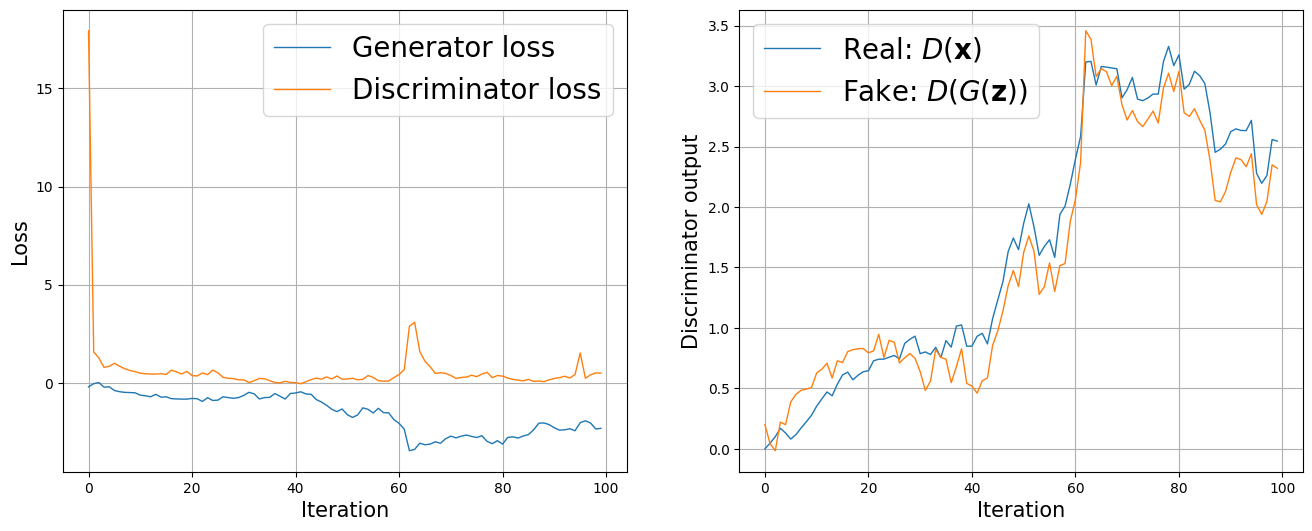

In [ ]:
fig = plt.figure(figsize=(16, 6))
## Plotting the losses
ax= fig.add_subplot(1,2,1)
plt.plot(all_g_losses, label='Generator loss')
half_d_losses=[all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax= fig.add_subplot(1,2,2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
plt.show()

tensor(0.)


<function matplotlib.pyplot.show(close=None, block=None)>

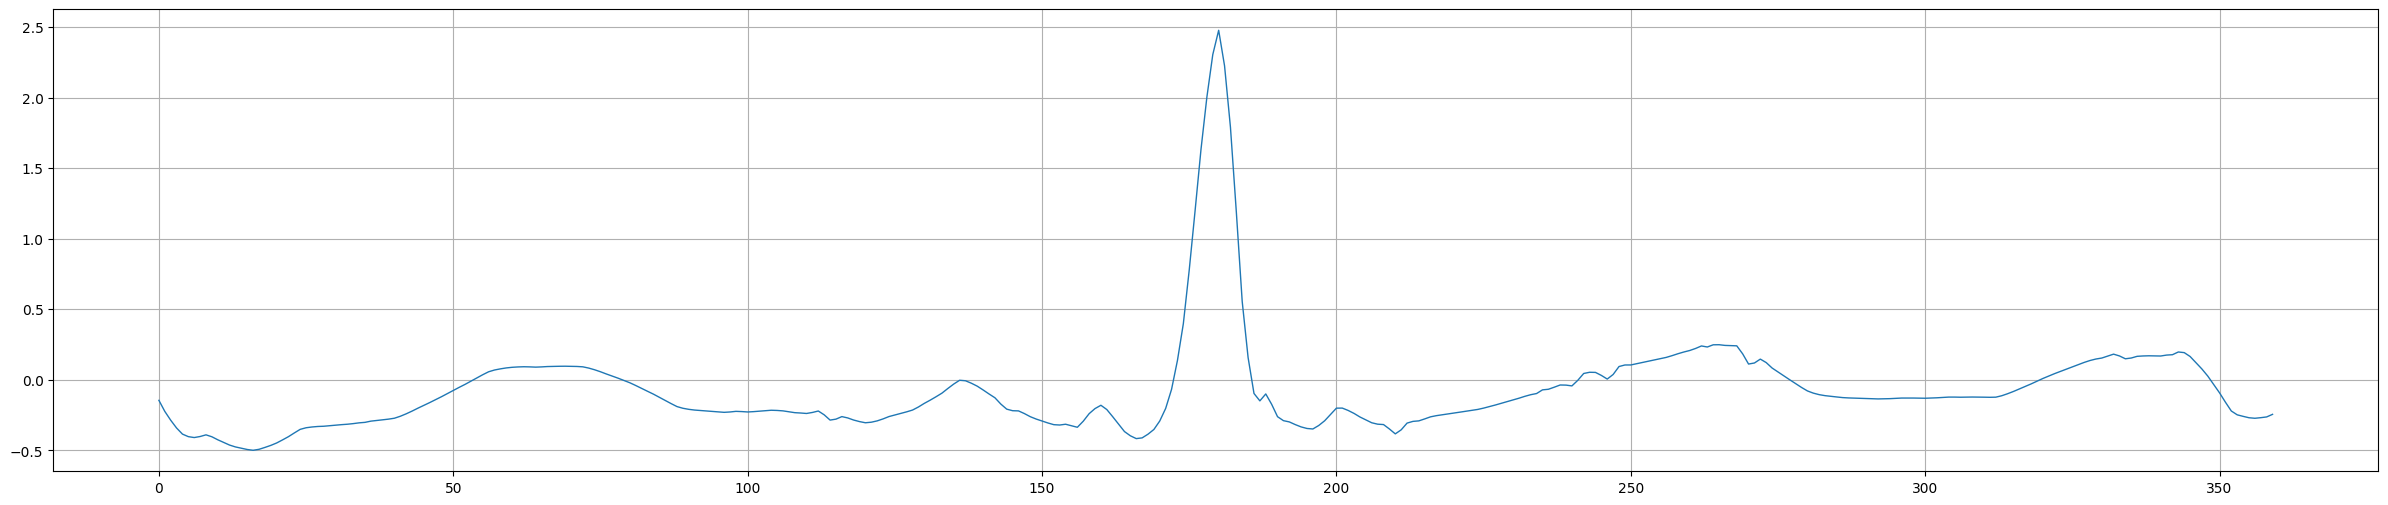

In [ ]:
# check data
a=1900
image = X_balanced[a]
print(y_balanced[a])
plt.plot(image)
plt.show

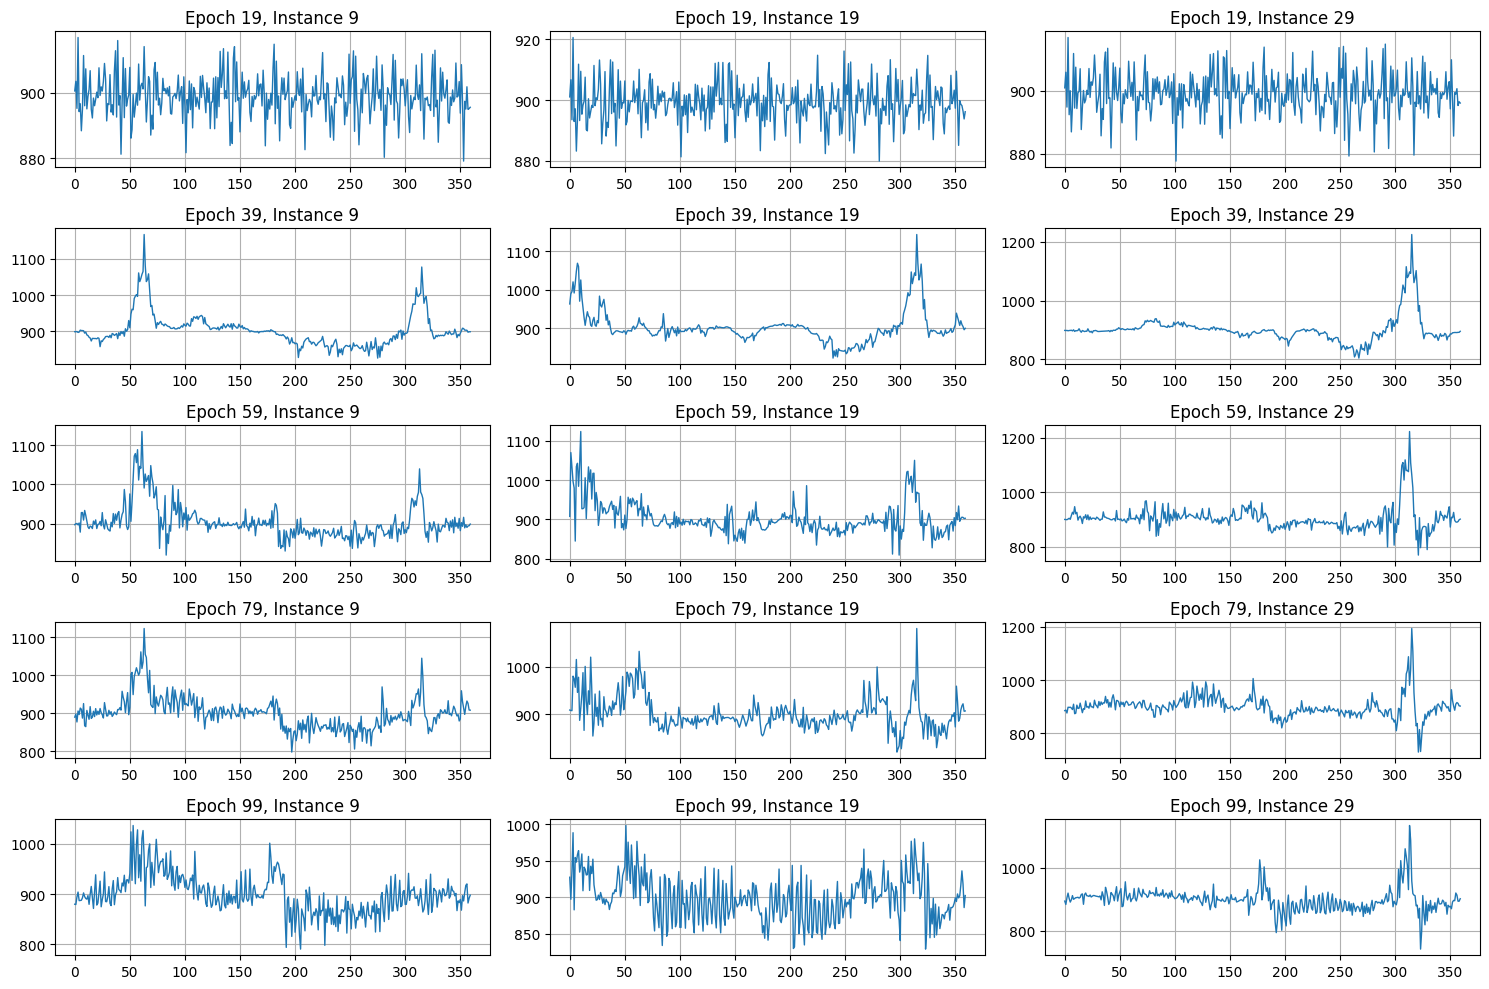

In [ ]:
import matplotlib.pyplot as plt

epochs = [19, 39, 59, 79, 99]
instances = [9, 19, 29]

fig, axes = plt.subplots(len(epochs), len(instances), figsize=(15, 10))

for i, epoch in enumerate(epochs):
    for j, instance in enumerate(instances):
        image = epoch_samples_wgan[epoch][instance]

        image_re = 900 + image[0] * 350 / 6.5
        image_deno = denoise(image_re)

        ax = axes[i, j]
        ax.plot(image_deno)
        ax.set_title(f"Epoch {epoch}, Instance {instance}")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Vanilla GAN

In [ ]:
# Vanilla GAN
def make_vanilla_generator(input_size= 100, num_output_units=360):
  model=nn.Sequential()


  model.add_module(f'fc_g{0}', nn.Linear(input_size, 360))
  model.add_module(f'relu_g{0}', nn.LeakyReLU())

  model.add_module(f'fc_g{1}', nn.Linear(360, 720))
  model.add_module(f'relu_g{1}', nn.LeakyReLU())

  model.add_module(f'fc_g{2}', nn.Linear(720, 1080))
  model.add_module(f'relu_g{2}', nn.LeakyReLU())

  model.add_module(f'fc_g{3}', nn.Linear(1080, 720))
  model.add_module(f'relu_g{3}', nn.LeakyReLU())

  model.add_module(f'fc_g{4}', nn.Linear(720, 540))
  model.add_module(f'relu_g{4}', nn.LeakyReLU())

  model.add_module(f'fc_g{5}', nn.Linear(540, 360))
  model.add_module(f'tanh_g', nn.Tanh())

  return model

def make_vanilla_discriminator(input_size= 360, num_output_units=1):
  model=nn.Sequential()


  model.add_module(f'fc_d{0}', nn.Linear(input_size, 240))
  model.add_module(f'relu_d{0}', nn.LeakyReLU())
  model.add_module(f'dropout', nn.Dropout(p=0.1))

  model.add_module(f'fc_d{1}', nn.Linear(240, 150))
  model.add_module(f'relu_d{1}', nn.LeakyReLU())
  model.add_module(f'dropout', nn.Dropout(p=0.1))

  model.add_module(f'fc_d{2}', nn.Linear(150, 90))
  model.add_module(f'relu_d{2}', nn.LeakyReLU())
  model.add_module(f'dropout', nn.Dropout(p=0.1))

  model.add_module(f'fc_d{3}', nn.Linear(90, 30))
  model.add_module(f'relu_d{3}', nn.LeakyReLU())
  model.add_module(f'dropout', nn.Dropout(p=0.1))

  model.add_module(f'fc_d{4}', nn.Linear(30, 1))
  model.add_module(f'sigmoid', nn.Sigmoid())

  return model

In [ ]:
# initate weights for vanilla GAN
def initialize_weights_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


In [ ]:
# n_filters =16
# hb_size=(1, 360)

torch.manual_seed(1)
np.random.seed(1)

# Model
vani_gen = make_vanilla_generator().to(device)
vani_disc= make_vanilla_discriminator().to(device)

vani_gen.apply(initialize_weights_kaiming)
vani_disc.apply(initialize_weights_kaiming)

# initial weights

# Loss function
loss_fn = nn.BCELoss()
va_g_optimizer=torch.optim.Adam(vani_gen.parameters(), lr=0.00025)
va_d_optimizer=torch.optim.Adam(vani_disc.parameters(), lr=0.00001)

In [ ]:
# print(vani_gen)
# print(vani_disc)

Sequential(
  (fc_g0): Linear(in_features=100, out_features=360, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=360, out_features=540, bias=True)
  (relu_g1): LeakyReLU(negative_slope=0.01)
  (fc_g2): Linear(in_features=540, out_features=720, bias=True)
  (relu_g2): LeakyReLU(negative_slope=0.01)
  (fc_g3): Linear(in_features=720, out_features=540, bias=True)
  (relu_g3): LeakyReLU(negative_slope=0.01)
  (fc_g4): Linear(in_features=540, out_features=360, bias=True)
  (tanh_g): Tanh()
)
Sequential(
  (fc_d0): Linear(in_features=360, out_features=240, bias=True)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=240, out_features=150, bias=True)
  (relu_d1): LeakyReLU(negative_slope=0.01)
  (fc_d2): Linear(in_features=150, out_features=90, bias=True)
  (relu_d2): LeakyReLU(negative_slope=0.01)
  (fc_d3): Linear(in_features=90, out_features=30, bias=True)
  (relu_d3): LeakyReLU(negative

In [ ]:
# Train method (from the book)
def va_d_train(x):
  vani_disc.zero_grad()
  # Train discriminator with a real batch
  batch_size=x.size(0)
  x.view(batch_size, -1).to(device)
  # debug: print(x.shape)
  d_labels_real=torch.ones(batch_size,1,device=device)
  d_proba_real=vani_disc(x)
  # debug: print('OK')
  d_loss_real=loss_fn(d_proba_real,d_labels_real)
  # Train discriminator on a fake batch
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  input_z= input_z.view(32, 100)
  g_output=vani_gen(input_z)
  d_proba_fake=vani_disc(g_output)
  d_labels_fake=torch.zeros(batch_size, 1, device=device)
  d_loss_fake=loss_fn(d_proba_fake, d_labels_fake)
  # gradient backprop & optimize ONLY D's parameters
  d_loss=d_loss_real + d_loss_fake
  d_loss.backward()
  va_d_optimizer.step()

  return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

# train the generator
def va_g_train(x):
  vani_gen.zero_grad()
  batch_size=x.size(0)
  input_z=create_noise(batch_size, z_size, mode_z).to(device)
  input_z=input_z.view(32, 100)
  g_labels_real=torch.ones(batch_size,1,device=device)

  g_output=vani_gen(input_z)
  d_proba_fake=vani_disc(g_output)
  g_loss=loss_fn(d_proba_fake, g_labels_real)

  # gradient backprop & optimize ONLY G's parameters
  g_loss.backward()
  va_g_optimizer.step()
  return g_loss.data.item()

In [ ]:
# debug
# test_va_ge=make_vanilla_generator()
# noise = create_noise(32, 100, 'uniform')
# print(noise.shape)
# noise = torch.randn((32, 100, 100))
# noise=noise.view(32, 100)
# output=test_va_ge(noise)
# output.shape


torch.Size([32, 100, 1])


torch.Size([32, 360])

In [ ]:
# test_va_disc=make_vanilla_discriminator()
# noise = torch.randn((32, 360))
# output=test_va_disc(noise)
# output.shape

torch.Size([32, 1])

In [ ]:
# test
# for i, (x, _) in enumerate(train_loader):

#  print(x.shape)

#  break

torch.Size([32, 360])


In [ ]:
z_size=100
hb_size=(1, 360)
batch_size=32
mode_z= 'normal'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
fixed_z = fixed_z.view(32, 100)

vani_epoch_samples=[]
all_d_losses=[]
all_g_losses=[]
all_d_real=[]
all_d_fake=[]
num_epochs= 100

# train_loader should be used as the whole dataset
for epoch in range(1, num_epochs+1):
  d_losses, g_losses=[], []
  d_vals_real, d_vals_fake=[], []
  for i, (x, _) in enumerate(train_loader):
    x=x.to(device)
    d_loss, d_proba_real, d_proba_fake=va_d_train(x)
    d_losses.append(d_loss)
    g_losses.append(va_g_train(x))
    d_vals_real.append(d_proba_real.mean().cpu())
    d_vals_fake.append(d_proba_fake.mean().cpu())

  all_d_losses.append(torch.tensor(d_losses).mean())
  all_g_losses.append(torch.tensor(g_losses).mean())
  all_d_real.append(torch.tensor(d_vals_real).mean())
  all_d_fake.append(torch.tensor(d_vals_fake).mean())
  print(f'Epoch {epoch:03d} | AVg Losses >>'
        f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
        f' [D-Real: {all_d_real[-1]:.4f}'
        f' D-Fake: {all_d_fake[-1]:.4f}]')
  vani_epoch_samples.append(
      create_samples(vani_gen, fixed_z).detach().cpu().numpy()
  )

Epoch 001 | AVg Losses >> G/D 0.0303/5.3329 [D-Real: 0.5086 D-Fake: 0.9731]
Epoch 002 | AVg Losses >> G/D 0.1121/2.9410 [D-Real: 0.6315 D-Fake: 0.8987]
Epoch 003 | AVg Losses >> G/D 0.1251/3.0007 [D-Real: 0.6345 D-Fake: 0.8884]
Epoch 004 | AVg Losses >> G/D 0.0985/3.2630 [D-Real: 0.5424 D-Fake: 0.9110]
Epoch 005 | AVg Losses >> G/D 0.1535/2.8455 [D-Real: 0.5341 D-Fake: 0.8622]
Epoch 006 | AVg Losses >> G/D 0.1884/2.5944 [D-Real: 0.5455 D-Fake: 0.8343]
Epoch 007 | AVg Losses >> G/D 0.2682/2.2285 [D-Real: 0.5584 D-Fake: 0.7713]
Epoch 008 | AVg Losses >> G/D 0.3197/2.0501 [D-Real: 0.5697 D-Fake: 0.7351]
Epoch 009 | AVg Losses >> G/D 0.4354/1.6664 [D-Real: 0.6616 D-Fake: 0.6650]
Epoch 010 | AVg Losses >> G/D 0.3826/1.9138 [D-Real: 0.5390 D-Fake: 0.6917]
Epoch 011 | AVg Losses >> G/D 0.5796/1.5020 [D-Real: 0.5619 D-Fake: 0.5669]
Epoch 012 | AVg Losses >> G/D 0.4327/1.6854 [D-Real: 0.5935 D-Fake: 0.6567]
Epoch 013 | AVg Losses >> G/D 0.6104/1.3170 [D-Real: 0.6966 D-Fake: 0.5561]
Epoch 014 | 

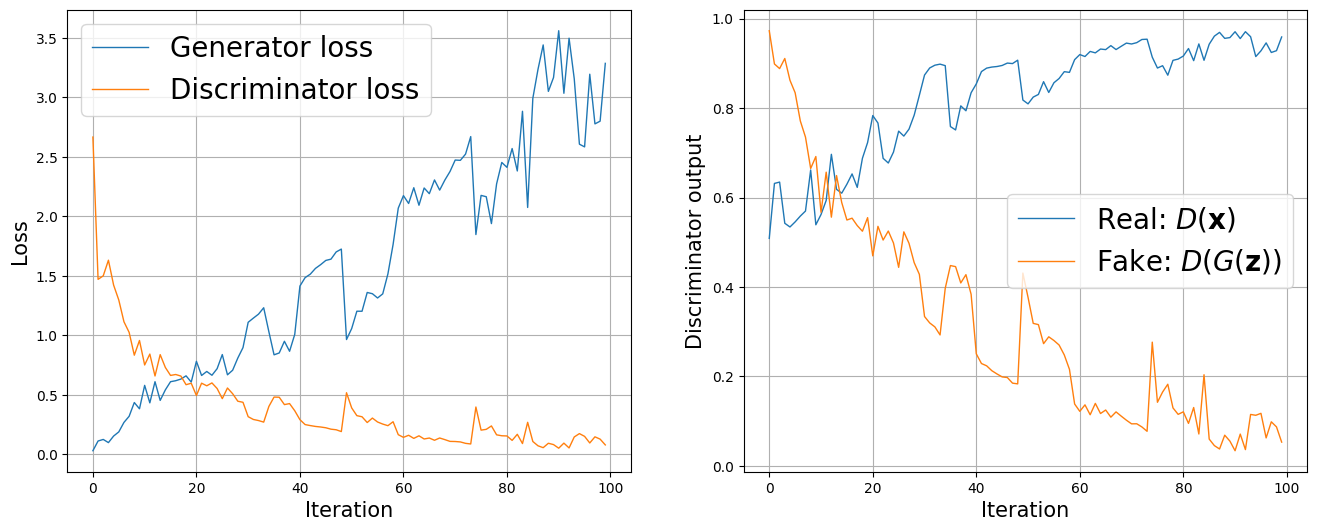

In [ ]:
fig = plt.figure(figsize=(16, 6))
## Plotting the losses
ax= fig.add_subplot(1,2,1)
plt.plot(all_g_losses, label='Generator loss')
half_d_losses=[all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax= fig.add_subplot(1,2,2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
plt.show()

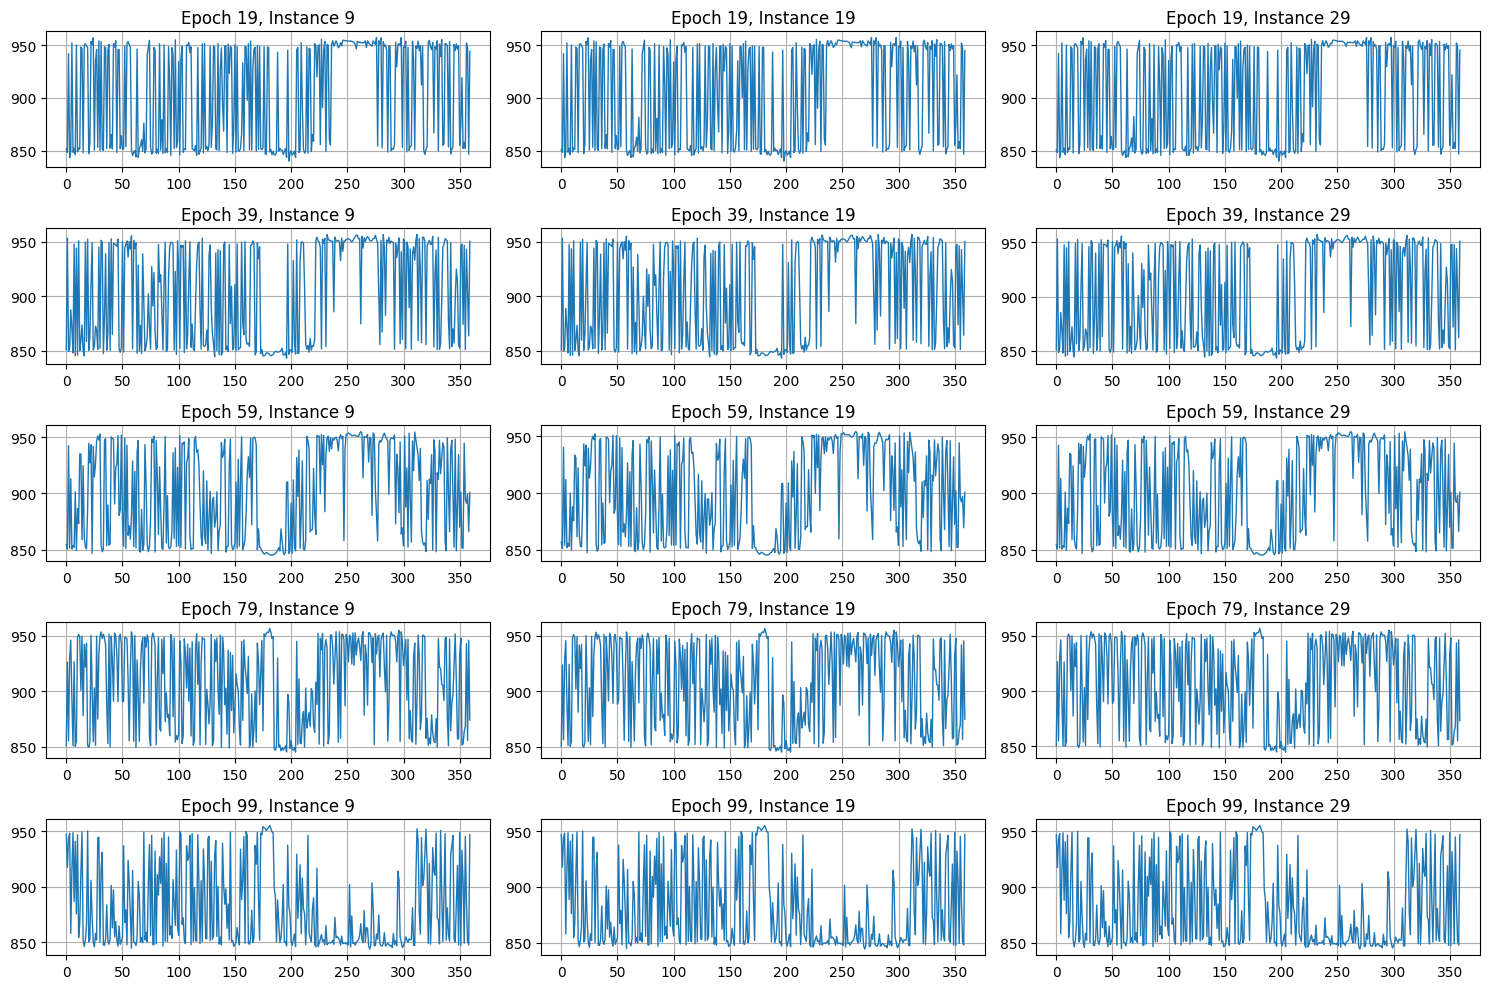

In [ ]:
epochs = [19, 39, 59, 79, 99]
instances = [9, 19, 29]

fig, axes = plt.subplots(len(epochs), len(instances), figsize=(15, 10))

for i, epoch in enumerate(epochs):
    for j, instance in enumerate(instances):
        image = vani_epoch_samples[epoch][instance]

        image_re = 900 + image[0] * 350 / 6.5
        image_deno = denoise(image_re)

        ax = axes[i, j]
        ax.plot(image_deno)
        ax.set_title(f"Epoch {epoch}, Instance {instance}")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
for epoch_index, epoch_data in enumerate(vani_epoch_samples):
    # Reshape the data for the current epoch to a 2D array of shape (32, 360).
    epoch_data_array = np.array(epoch_data).reshape(-1, 360)

    # Define the filename for the current epoch.
    filename = f'/content/drive/MyDrive/Abschlussarbeit_ECG/vanilla_GAN_17_12/epoch_{epoch_index+1}.csv'

    # Save the epoch data to a CSV file.
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(epoch_data)

# PGAN - Special loss function

In [ ]:
# Use neurokit2 to extract features
def get_features(ecg_signal):
  _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=360)
  _, waves_peak=nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=360, method='peak')

  return rpeaks['ECG_R_Peaks'], \
         waves_peak['ECG_T_Peaks'], \
         waves_peak['ECG_P_Peaks'], \
         waves_peak['ECG_Q_Peaks'], \
         waves_peak['ECG_S_Peaks']

In [ ]:
# process the features of a single patient
# custom the training process for a single patient
pa_heartbeats=list()
pa_annotations=list()
patient_feature= list()

patient_id = 36
patient_signal=read_csv_file(records[patient_id])

In [ ]:
R, T, P, Q, S = get_features(patient_signal)

In [ ]:
# length of R
print(len(R))

2207


In [ ]:
# Caculate the relative pqrst peaks position
r_q_tensor = torch.tensor(R) -torch.tensor(Q)
r_p_tensor = torch.tensor(R) -torch.tensor(P)
r_s_tensor =  torch.tensor(S) - torch.tensor(R)
r_t_tensor = torch.tensor(T) -torch.tensor(R)
relative_R = 180*torch.ones(len(R))
relative_Q = relative_R - r_q_tensor
relative_P = relative_R - r_p_tensor
relative_S = relative_R + r_s_tensor
relative_T = relative_R + r_t_tensor

In [ ]:
rela_peaks = torch.stack((relative_P, relative_Q,relative_R,relative_S,relative_T)).T
abs_peaks = torch.stack((torch.tensor(P),torch.tensor(Q),torch.tensor(R),torch.tensor(S),torch.tensor(T))).T
# cut the nan
# rela_peaks = rela_peaks[:500]
# abs_peaks= abs_peaks[:500]

In [ ]:
# Eliminate rows which contain Nans in the tensor
rows_with_nans = torch.isnan(rela_peaks).any(dim=1)
rela_peaks =rela_peaks[~rows_with_nans]
rows_with_nans = torch.isnan(abs_peaks).any(dim=1)
abs_peaks =abs_peaks[~rows_with_nans]

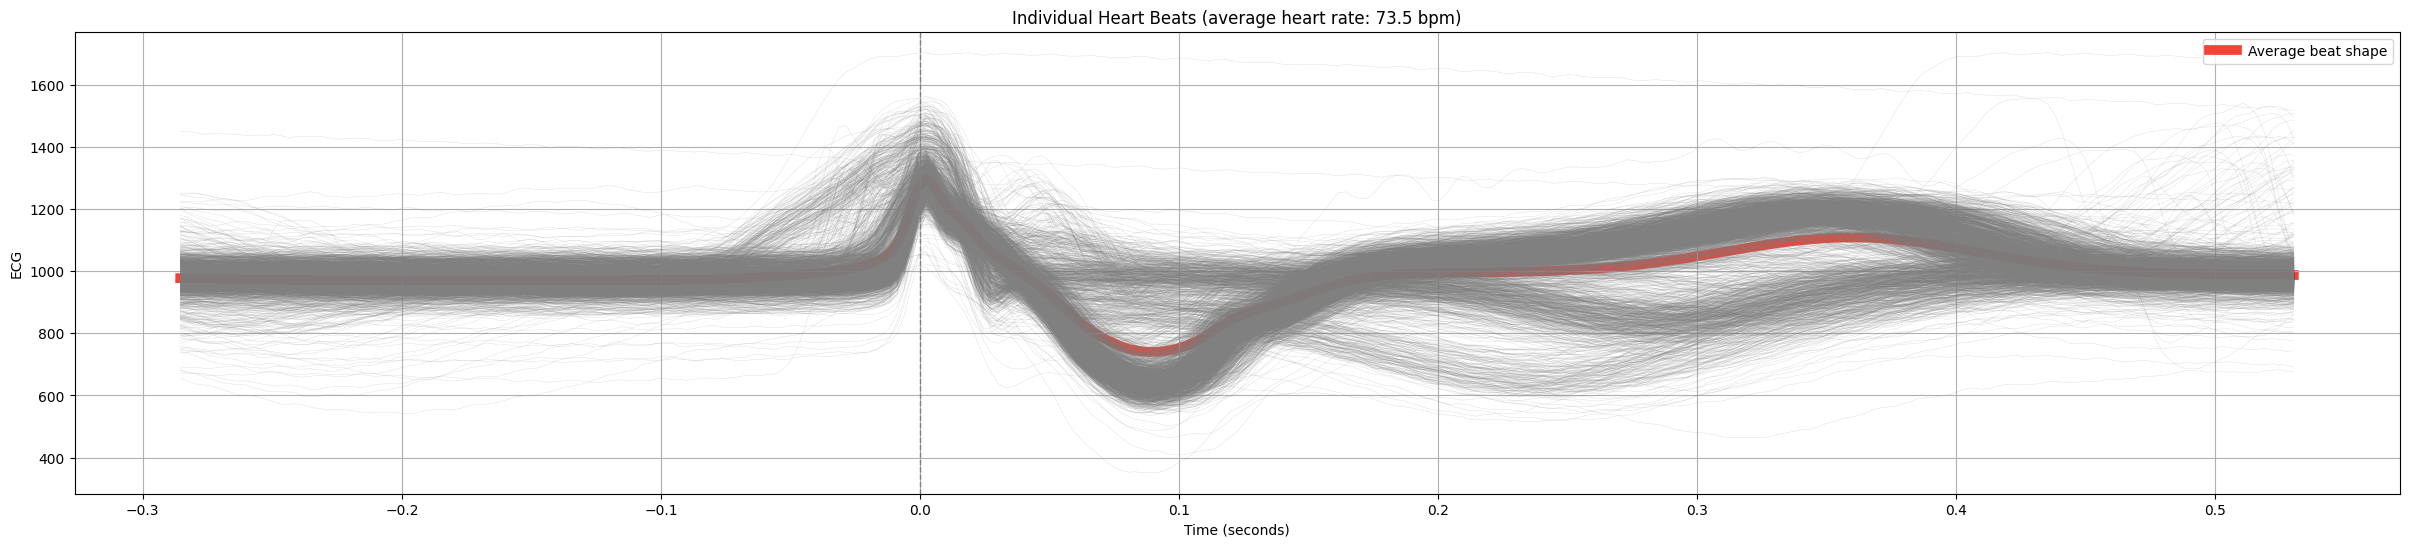

In [ ]:
# Analysis of the signal
_, rpeaks = nk.ecg_peaks(patient_signal, sampling_rate=360)
epochs = nk.ecg_segment(patient_signal, rpeaks=rpeaks['ECG_R_Peaks'], sampling_rate=360, show=True)

In [ ]:
abs_peaks = abs_peaks.to(device)
rela_peaks = rela_peaks.to(device)
patient_signal = torch.tensor(patient_signal).to(device)

In [ ]:
# samples from patient signal with peaks
plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:3],
                       waves_peak['ECG_P_Peaks'][:3],
                       waves_peak['ECG_Q_Peaks'][:3],
                       waves_peak['ECG_S_Peaks'][:3]], patient_signal[:1600])

NameError: ignored

In [ ]:
# training method for PGAN
# a is the coefficient of the normal loss, (1-a) is the rate of morphological loss
def train_generator_pwgan(x, patient_records):
  gen_model.zero_grad()

  batch_size=x.size(0)
  input_z=create_noise(batch_size, z_size, mode_z).to(device)
  g_output=gen_model(input_z)
  # print(g_output.shape)

  d_generated= disc_model(g_output)
  g_output = g_output.to(device)
  d_generated = d_generated.to(device)
  g_loss=a*(-d_generated.mean()) + (1-a) * mo_loss(g_output, abs_peaks, rela_peaks, patient_records)

  g_loss.backward()
  g_optimizer.step()
  return g_loss.data.item()

In [ ]:
# morphological loss functions
def mo_loss(gen_beats, abs_peaks, rela_peaks, patient_records):
  gen_beats = gen_beats.squeeze(1).to(device)
  # Scale the records to the same range as gen_beats
  gen_max= torch.max(gen_beats)
  gen_min= torch.min(gen_beats)
  records= torch.tensor(patient_records).to(device)
  re_max=torch.max(records)
  re_min=torch.min(records)
  normalized_records = (records - re_min)/(re_max-re_min)
  scaled_records=normalized_records *(gen_max -gen_min) + gen_min


  # pick 32 random heartbeats of the patient
  rand = torch.randint(0, 2000, (32,))
  selected_abs_peaks = abs_peaks[rand]
  selected_rela_peaks = rela_peaks[rand]

  # extract characters of generated heartbeats
  row_indices = torch.arange(gen_beats.size(0), dtype=torch.long).unsqueeze(1).expand(-1, selected_rela_peaks.size(1))
  # print(f"row_indices shape: {row_indices.shape}" )
  # print(f"sle peak shape: {selected_rela_peaks.shape}")
  selected_rela_peaks = selected_rela_peaks.long()
  gen_features= gen_beats[row_indices, selected_rela_peaks].float()

  # real heartbeats feature
  selected_abs_peaks = selected_abs_peaks.long()
  real_features= torch.zeros_like(selected_abs_peaks, dtype=float)
  for i in range(selected_abs_peaks.size(0)):
    for j in range(selected_abs_peaks.size(1)):
        real_features[i, j] = records[selected_abs_peaks[i, j]]
  real_features= real_features.float()
  # MSE
  gen_row_sum =torch.sum(gen_features, dim=1).to(device)
  real_row_sum =torch.sum(real_features, dim=1).to(device)
  return F.mse_loss(gen_row_sum, real_row_sum)

In [ ]:
# Load generator model and optimizer state
g_checkpoint = torch.load('/content/drive/MyDrive/Abschlussarbeit_ECG/model/wgan_gen_model.pth')
gen_model.load_state_dict(g_checkpoint['model_state_dict'])

# Load discriminator model and optimizer state
d_checkpoint = torch.load('/content/drive/MyDrive/Abschlussarbeit_ECG/model/wgan_disc_model.pth')
disc_model.load_state_dict(d_checkpoint['model_state_dict'])

# initialize ooptimizer
g_optimizer=torch.optim.Adam(gen_model.parameters(), lr=0.00005)
d_optimizer=torch.optim.Adam(disc_model.parameters(), lr=0.00005)
d_optimizer.load_state_dict(d_checkpoint['optimizer_state_dic'])
g_optimizer.load_state_dict(g_checkpoint['optimizer_state_dic'])

In [ ]:
# import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# train PGAN, use the model trained by normal WGAN
a = 0.50
epoch_samples_pwgan = []
lambda_gp=10.0
num_epochs=60
# torch.manual_seed(1)
critic_iterations=5
all_d_losses=[]
all_g_losses=[]
all_d_real=[]
all_d_fake=[]
for epoch in range(1, num_epochs+1):
  gen_model.train()
  d_losses,g_losses=[],[]
  d_vals_real, d_vals_fake=[], []
  for i, (x,_) in enumerate(train_loader):
    x=x.unsqueeze(1)
    for _ in range(critic_iterations):
      d_loss, d_proba_real, d_proba_fake = d_train_wgan(x)
    d_losses.append(d_loss)
    g_losses.append(train_generator_pwgan(x, patient_signal))
    d_vals_real.append(d_proba_real.mean().cpu())
    d_vals_fake.append(d_proba_fake.mean().cpu())

  all_d_losses.append(torch.tensor(d_losses).mean())
  all_g_losses.append(torch.tensor(g_losses).mean())
  all_d_real.append(torch.tensor(d_vals_real).mean())
  all_d_fake.append(torch.tensor(d_vals_fake).mean())

  print(f'Epoch {epoch:03d} | D Loss >>'
        f' {torch.FloatTensor(d_losses).mean(): .4f}')
  gen_model.eval()
  epoch_samples_pwgan.append(
      create_samples(
          gen_model, fixed_z
      ).detach().cpu().numpy()
  )

# save the generated data to csv file
import csv
from google.colab import files

for epoch_index, epoch_data in enumerate(epoch_samples_pwgan):
    # Reshape the data for the current epoch to a 2D array of shape (32, 360).
    epoch_data_array = np.array(epoch_data).reshape(-1, 360)

    # Define the filename for the current epoch.
    filename = f'/content/drive/MyDrive/Abschlussarbeit_ECG/17_12_PGAN_a_05/epoch_{epoch_index+1}.csv'

    # Save the epoch data to a CSV file.
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(epoch_data)

<ipython-input-46-f1e5e4f562cb>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  records= torch.tensor(patient_records).to(device)


RuntimeError: ignored

In [ ]:
# save wgan model
# discriminator model
torch.save({
    'model_state_dict': disc_model.state_dict(),
    'optimizer_state_dic': d_optimizer.state_dict(),
}, '/content/drive/MyDrive/Abschlussarbeit_ECG/model/pwgan_disc_model_05.pth')

# generator model
torch.save({
    'model_state_dict': gen_model.state_dict(),
    'optimizer_state_dic': g_optimizer.state_dict(),
}, '/content/drive/MyDrive/Abschlussarbeit_ECG/model/pwgan_gen_model_05.pth')

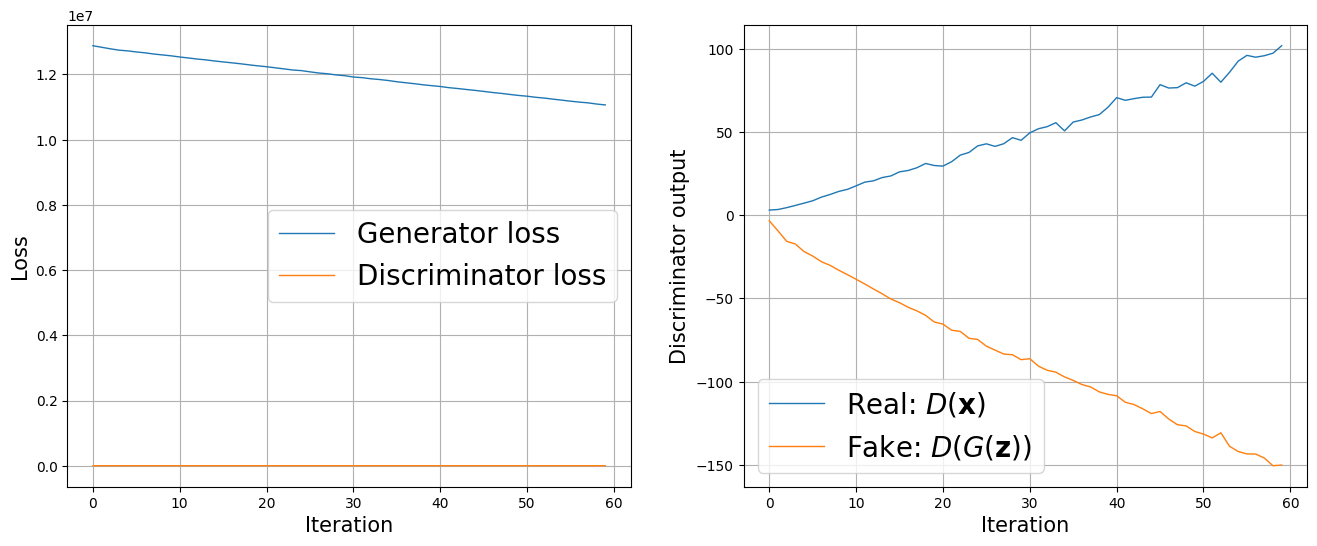

In [ ]:
fig = plt.figure(figsize=(16, 6))
## Plotting the losses
ax= fig.add_subplot(1,2,1)
plt.plot(all_g_losses, label='Generator loss')
half_d_losses=[all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax= fig.add_subplot(1,2,2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
plt.show()

In [ ]:
print(torch.tensor(epoch_samples_pwgan).shape)

torch.Size([60, 32, 1, 360])


<ipython-input-54-120db9558ddc>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  print(torch.tensor(epoch_samples_pwgan).shape)


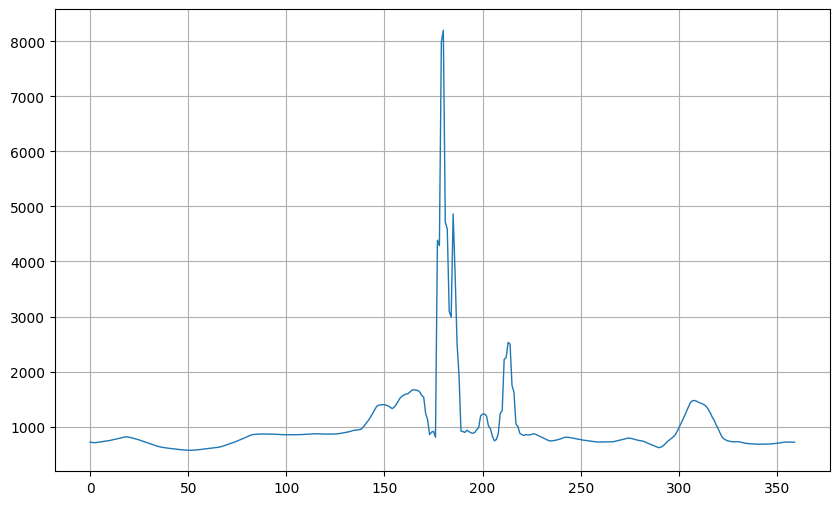

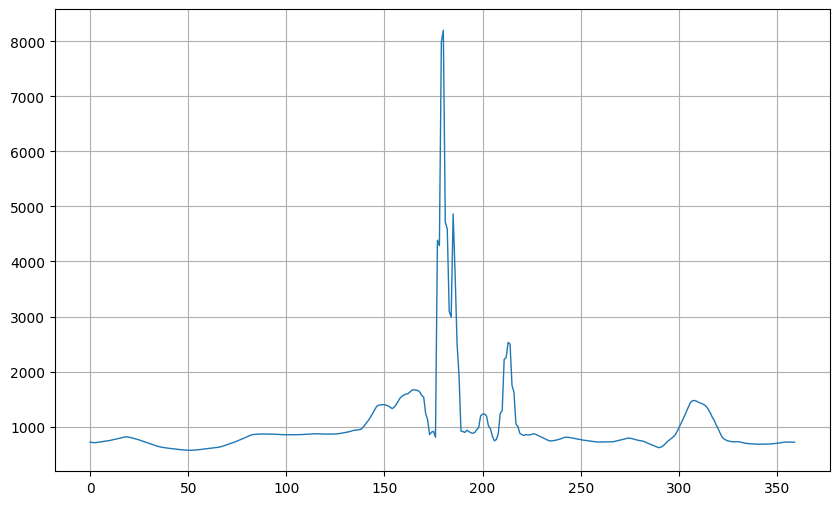

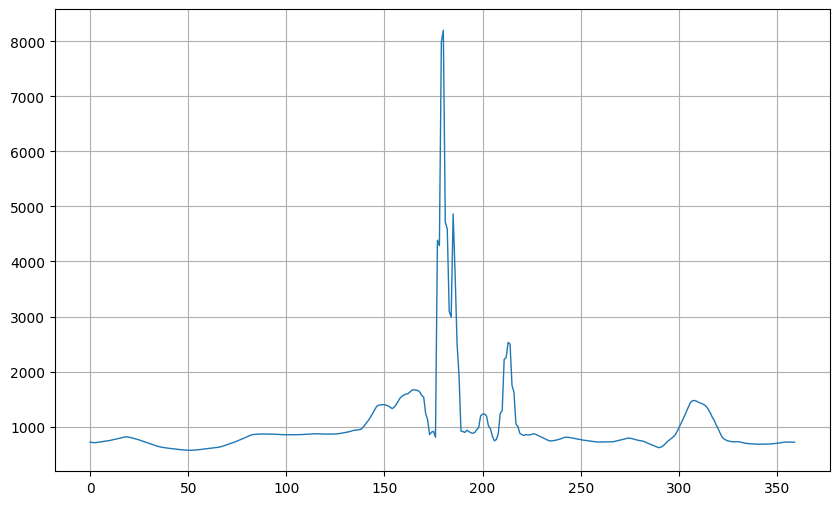

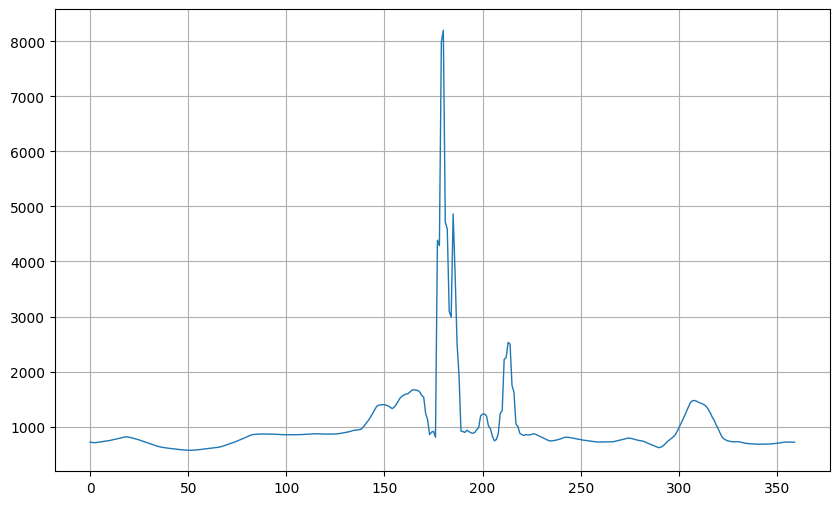

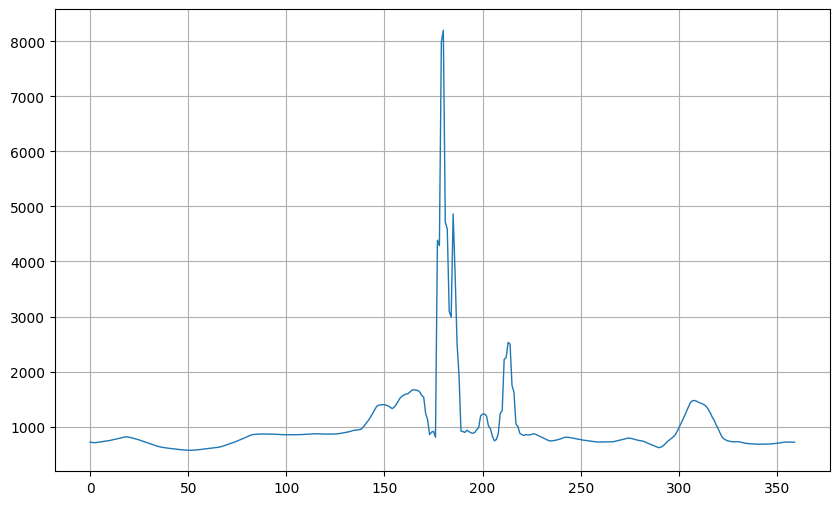

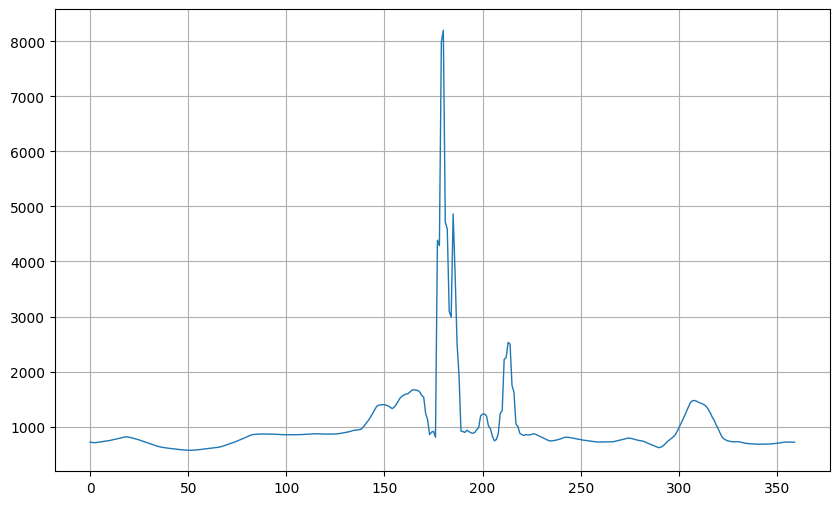

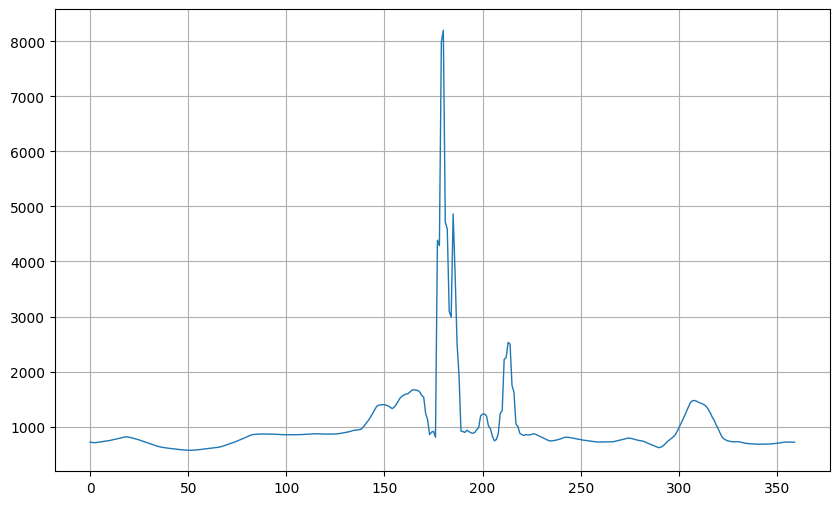

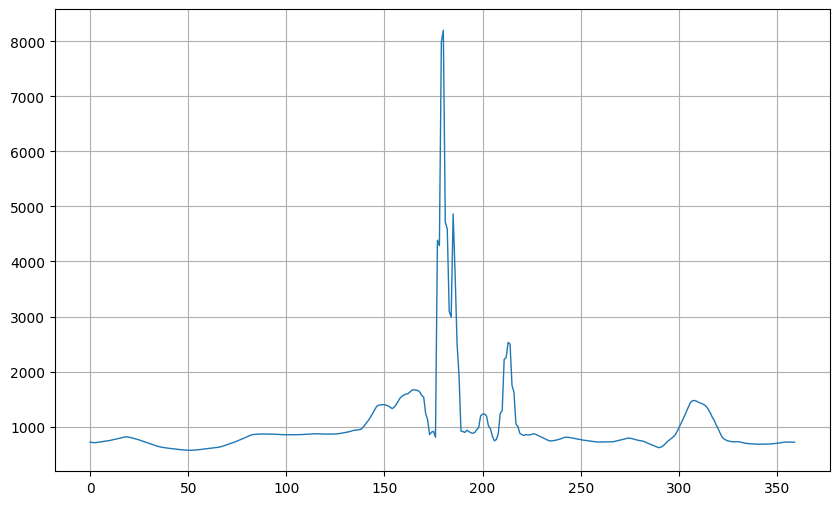

In [ ]:
for i in [5, 25,45,59]:
  for j in [5, 25]:
    # check output
    plt.figure(figsize=(10, 6))
    image=epoch_samples_pwgan[25][25]
    # print(image)
# plt.plot(image[0])
    image_re = 900 + image[0]*350/6.5
    image_deno= denoise(image_re)
# print(image_deno)
    plt.plot(image_deno)
    # ex.set_ylim([0,])
    plt.show